## Seasonal Analysis with Xarray.

As a complement for the annual cycle kind of analysis, where we have one average value for each calendar month, there's also the seasonal kind of analysis based on the seasons of the year (hence the name).

Xarray also provides us with a way to do this, but as was discussed [here](https://github.com/pydata/xarray/issues/810) the pandas-based solution might not be the best one. Also, there are times when you simply don't want to use the "official" seasons and want to define them yourself. 

The following example gives one simple solution among many. 

In [1]:
import matplotlib.pyplot   as plt
import cartopy.crs         as ccrs
import cartopy.feature     as cf
import cartopy             as cartopy
import numpy               as np
import xarray              as xr
import datetime


from functions    		   import* # from functions.py
from cartopy.mpl.ticker    import LongitudeFormatter, LatitudeFormatter

Have in mind that we will use the Class version of the annual cycle analysis made in the [last notebook](http://nbviewer.jupyter.org/github/willyhagi/climate-statistics/blob/master/Jupyter-Notebooks/annual_cycle.ipynb), which will be imported here from the ['functions.py'](https://github.com/willyhagi/climate-statistics/blob/master/Python-Scripts/functions.py) script you can get at the repository.

In [2]:
##----- read netcdf file
dset  =  xr.open_dataset('precip.mon.total.1x1.v7.nc')
var   =  dset['precip'][:,:,:]
lat   =  dset['lat'][:]
lon   =  dset['lon'][:]



##----- if you want to select a certain area (and time) 

# south america
lat1  =  12  
lat2  =  -50  
lon1  =  270  
lon2  =  330  


time1 = '1981-1-1' ; time2 = '2010-12-1'



##----- numpy array converting
lon  =  var.sel(lon=slice(lon1,lon2))  
lon  =  np.asarray(lon.lon.values)

lat  =  var.sel(lat=slice(lat1,lat2)) 
lat  =  np.asarray(lat.lat.values)


##----- slicing
var  =  var.sel(lat=slice(lat1,lat2),
                lon=slice(lon1,lon2),
                time=slice(time1,time2))

Our simple solution comes now. Let's define the JJA season (austral winter or boreal summer) using an array with the corresponding month numbers.

In [3]:
print (var.shape)

(360, 62, 60)


As you can see, we have all the months for the 1981-2010 period.  

In [4]:
class Seasonal:
    def __init__(self, data, m1, m2, m3): # this can be extended to n months
        self.data  =  data
        self.m1    =  m1
        self.m2    =  m2
        self.m3    =  m3

    def select_months(self, month):
        return (month == self.m1) | (month == self.m2) | (month == self.m3)

    def season(self):
        # season will return n months for the whole time period of your dataset
        self.svar =  self.data.sel(time = self.select_months(self.data['time.month']))
        return self.svar

This simple class says: we will take from the parameter 'month' those values with months numbered (from 1 to 12) by m1, m2 and m3. The '|' symbol is a bitwise 'or' operator, you can learn more about those logical structures [here.](https://wiki.python.org/moin/BitwiseOperators)

Then Xarray comes to the rescue at the 'season' function and we select the months for our dataset with the 'sel' argument.

In [5]:
jja  =  Seasonal(var, 6, 7, 8)  # putting it to work...
jja  =  jja.season()

In [6]:
print (jja.shape)

(90, 62, 60)


Now we have 90 months for our JJA season from the 1981-2010 period, exactly as it should be! The following code is just the annual cycle all over again, hope you're not already bored.

In [7]:
#--- gridded seasonal averages
ijja  =  Demean(jja, lat1, lat2, lon1, lon2, time1, time2)
mjja  =  ijja.average()
mjja  =  mjja.mean(axis=0)

In [8]:
print (mjja.shape)

(62, 60)


The only difference is that we are using the 'Demean' class designed for the annual cycle (from functions.py). On the first 'mjja' line, we still don't have the seasonal average as we want; we will get it at the last line, with the 'mean' argument (check this out!).

Onwards to the fun part, plotting! 

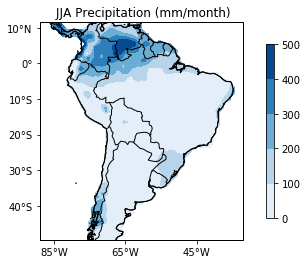

In [9]:
##----------------------- PLOTTING
plt.figure(figsize=(8,4))
proj  =  ccrs.PlateCarree()
ax = plt.axes(projection=proj)
inter = np.arange(0, 600, 100)

#ax.set_extent([250, 340, -50, 15], proj)             
ax.add_feature(cf.BORDERS)
ax.add_feature(cf.COASTLINE)
ax.coastlines(resolution='50m',color='black')
x_lons = np.arange(-85,-15,20) 
y_lats = np.arange(-70,50,10)
tick_fs = 16
ax.set_xticks(x_lons, minor=False, crs=proj)
ax.set_yticks(y_lats, minor=False, crs=proj)
lon_formatter = LongitudeFormatter(zero_direction_label=True,
                                   number_format='.0f')
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

plt.contourf(lon, lat, mjja, inter,
             transform=proj,
             cmap=plt.get_cmap('Blues'))
plt.colorbar(ax=ax, shrink=0.8)
plt.title(u' JJA Precipitation (mm/month)')

plt.show()

We will rely heavily on the 'Seasonal' and 'Demean' classes for the next notebooks, so I hope things are clear now. As I said before, the solutions given here are just a few of the possible solutions one can get to solve those problems. The ones we just saw are mere experiments which work for the time, but there's a lot to do yet.

And by the way, if you want to make an weighted average considering the number of days of each month the Xarray documentation has an [example](http://xarray.pydata.org/en/stable/examples/monthly-means.html) using the standard seasons. 

## EDIT

As discussed [here](https://stackoverflow.com/questions/48214357/select-xarray-pandas-index-based-on-a-list-of-months), the method above for the selection of months can impose limitations depending on the kind of analysis you might want to do. Another solution, which will be used and encouraged from now on, is the one following:

In [11]:
months = [6,7,8] # for JJA
season = var.sel(time = np.in1d( var['time.month'], months))

In [12]:
print (season.shape)

(90, 62, 60)


The above method will give us the same result as we did before (exercise left for the reader). Also, 'np.in1d' can be replaced for 'np.isin' according to more recent versions of NumPy.